In [1]:
# set width = 100%
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:99% !important; }</style>"))

In [22]:
%matplotlib inline
import matplotlib.pyplot as plt
import os
import tarfile
import urllib
import pandas as pd
import numpy as np
from zlib import crc32
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from pandas.plotting import scatter_matrix
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.utils.fixes import loguniform
import scipy.stats as stats

In [3]:
DOWNLOAD_ROOT = "https://github.com/ageron/handson-ml2/blob/master/"
HOUSING_PATH = os.path.join('datasets', 'housing')
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz?raw=true"
def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    os.makedirs(housing_path, exist_ok=True)
    tgz_path = os.path.join(housing_path,'housing.tgz')
    urllib.request.urlretrieve(housing_url,tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()
    
def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path,'housing.csv')
    return pd.read_csv(csv_path)

def split_train_test(data,test_ratio):
    np.random.seed(42)
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

def test_set_check(identifier, test_ratio):
    return crc32(np.int64(identifier)) & 0xffffffff < test_ratio*2**32

def split_train_test_by_id(data, test_ratio, id_column):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: test_set_check(id_,test_ratio))
    return data.loc[~in_test_set], data.loc[in_test_set]

def split_train_test_by_bin(data, label='median_income', bins=[0,1.5,3.0,4.5,6,np.inf],n_splits=1,test_size=0.2,random_state=42, plot_bins=50):
    # give bins a label
    bin_labels = range(len(bins)-1)
    # make new labels
    housing["bin_cuts"] = pd.cut(housing[label],bins=bins, labels = bin_labels)
    # setup split
    split = StratifiedShuffleSplit(n_splits=n_splits,test_size=test_size, random_state=random_state)
    for train_index, test_index in split.split(housing,housing['bin_cuts']):
        strat_train_set = housing.loc[train_index]
        strat_test_set = housing.loc[test_index]
    # drop the bin data for training
    for set_ in (strat_train_set, strat_test_set):
        set_.drop("bin_cuts", axis=1, inplace=True)
    # compare datasets
    strat_train_set['median_income'].hist(bins=plot_bins)
    strat_test_set['median_income'].hist(bins=plot_bins)
    return strat_train_set, strat_test_set

def train_fit_test(model, preped_data, labels):
    model.fit(preped_data,labels)
    predictions = model.predict(preped_data)
    mse = mean_squared_error(labels, predictions)
    rmse = np.sqrt(mse)
    print("RMSE:",rmse)
    return model

def display_scores(scores):
    print("Mean (std):", scores.mean(), "(" + str(scores.std()) + ")")
    
def train_fit_test_CV(model, preped_data, labels, scoring="neg_mean_squared_error", cv=10):
    scores = cross_val_score(model, preped_data, labels, scoring=scoring, cv=cv)
    rmse = np.sqrt(-scores)
    display_scores(rmse)
    return model

In [4]:
from sklearn.base import BaseEstimator, TransformerMixin

rooms_ix, bedrooms_ix, populations_ix, households_ix = 3,4,5,6

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room=True):
        self.add_bedrooms_per_room = add_bedrooms_per_room
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        rooms_per_household = X[:, rooms_ix] / X[:, households_ix]
        population_per_household = X[:,populations_ix] / X[:, households_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:,bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household, bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]


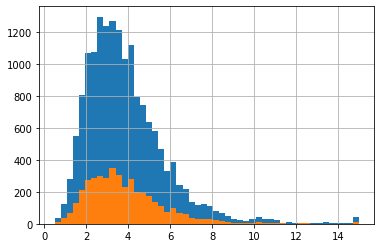

In [5]:
fetch_housing_data()
housing = load_housing_data()

strat_train_set, strat_test_set = split_train_test_by_bin(housing, label='median_income', bins=[0,1.5,3.0,4.5,6,np.inf])

In [6]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder 

housing = strat_train_set.drop("median_house_value",axis=1)
housing_labels = strat_train_set["median_house_value"].copy()

housing_num = housing.drop("ocean_proximity", axis=1)

num_attribs = list(housing_num)
cat_attribs = ['ocean_proximity']

num_pipeline = Pipeline([('imputer', SimpleImputer(strategy='median')), # put median in for Nan
                        ('attribs_adder', CombinedAttributesAdder()), # adds rooms per house and such
                       ('std_scaler', StandardScaler()), # scales data so it is consistant across parameters
                       ])

 
full_pipeline = ColumnTransformer([
    ('num', num_pipeline, num_attribs),
    ('cat', OneHotEncoder(), cat_attribs)
])

housing_prepared = full_pipeline.fit_transform(housing)


In [7]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor

model_list = [DecisionTreeRegressor(), LinearRegression(), SVR(), RandomForestRegressor()]
for model in model_list:
    train_fit_test_CV(model, housing_prepared, housing_labels, cv=10)
    print(model,"\n\n")



Mean (std): 70825.37223299823 (2729.289239216656)
DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best') 


Mean (std): 69052.46136345083 (2731.674001798349)
LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False) 


Mean (std): 118572.66762937943 (2936.8775867949425)
SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='scale',
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False) 


Mean (std): 50210.814281577084 (2009.0043788128173)
RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
       

In [30]:
from sklearn.model_selection import GridSearchCV
param_grid = [{"n_estimators":[3,10,30], 'max_features': [2,4,6,8]}, {'bootstrap':[False], 'n_estimators': [3,10], 'max_features':[2,3,4]}]
forest_reg = RandomForestRegressor()
grid_search = GridSearchCV(forest_reg, param_grid, cv=5, scoring="neg_mean_squared_error", return_train_score=True)
grid_search.fit(housing_prepared, housing_labels)
grid_search.best_estimator_

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features=6, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=30, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [31]:
from sklearn.model_selection import RandomizedSearchCV

param_dist = [{"kernel":['rbf'], 'C': stats.uniform(0.001, 10) , 'gamma': ['scale', 'auto']}, {"kernel":['rbf'], 'c': stats.uniform(0.001, 10)}]
n_iter_search = 5
random_search = RandomizedSearchCV(SVR(), param_distributions=param_dist,
                                   n_iter=n_iter_search)